# CNN-lytical Assignment-1
*  In this assignment, we will build a classifier for MNIST from scratch using just [NumPy](https://numpy.org/)

*  [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits of size 28x28

*  The dataset that you are expected to use for training can be found [here](https://drive.google.com/file/d/1z7lwIml6UxsNpDIW3_mPPEb8SoaPC5Zg/view)

*   Our model will have 1 hidden layer, like the one below (not our recommendation to use 256 in the hidden layer though, try various values out)

**Feel free to redefine any function signatures below, just make sure the final cell remains the same.**

<center>
<img src="https://user-images.githubusercontent.com/81357954/166119893-4ca347b8-b1a4-40b8-9e0a-2e92b5f164ae.png">
</center>

## Import libraries here
NumPy, Matplotlib, ...

Also remember to initialize the seed for reproducibility of results

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import pickle
np.random.seed(0)

## Load *Dataset*
Load data from the given pickle file

In [4]:

# load the data set
from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/MyDrive/train_data.pkl', 'rb') as f:
  data = pickle.load(f)

X = data['X']
y = data['y']

#shuffling X and y so that selection is random
p = np.random.permutation(len(X))
X = X[p]
y = y[p]

split = int(0.83*X.shape[0])
train_X = X[:split][:]
test_X = X[split:][:]
y = y.reshape(1, y.shape[0])
[y] = y
train_y = y[:split]
test_y = y[split:]
X_train = train_X
X_test = test_X

# making sure they are numpy arrays
X_train = np.array(X_train, dtype=np.float128)
X_test = np.array(X_test, dtype=np.float128)

y_train = train_y
y_test = test_y
# Now they are 2D arrays, with columns being different examples
# However, while extracting examples we need to take T again as it's easier to pinpoint examples that way and reshape them to (28, 28)
X_train = X_train.reshape(X_train.shape[0], 784).T
X_test = X_test.reshape(X_test.shape[0], 784).T
scale= preprocessing.StandardScaler()
X_train  = scale.fit_transform(X_train)
X_test  = scale.fit_transform(X_test)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


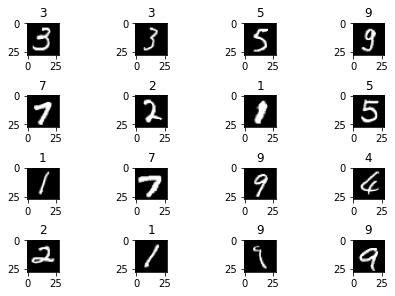

In [6]:
# display a 4x4 grid, 
# choose 16 images randomly, display the images as well as corresponding labels
f, axarr = plt.subplots(4, 4, constrained_layout = True)

for i in range(4):
  for j in range(4):
    number = np.random.randint(0, X_train.shape[1])
    axarr[i][j].imshow(X_train.T[number].reshape(28, 28), cmap = 'gray')
    axarr[i][j].set_title(y_train[number])

## Building up parts of our classifier

**Activation functions**

In [7]:
def relu(z):
    """
    Arguments:
    z -- A scalar or numpy array.
    Return:
    relu func applied to each element of z
    """
    # 0 < z creates a mask to be applied over z
    return (0 < z) * z

def softmax(z):
    """
    returns computed probabilitites for each element in batch separately
    input: (N, 10)
    output: (N, 10)
    """
    return np.exp(z)/np.sum(np.exp(z), axis=0, keepdims = True)


**Notes about the Neural Network** 
*   Input size is (784,) because 28x28 = 784
*   Output size will be 10, each element represeting probability of the image representing that digit
*   Size of the hidden layer is a hyperparameter



**Initialize the layers weights**

Generally, we follow the convention that weights are drawn from a standard normal distribution, while the bias vectors are initialized to zero. But you can try everything out :)

In [8]:
def init_params(layers_dims): # takes sizes of layers i.e. n_0. n_1, n_2
    """
    ideally it should take the size of all the layers and 
    should return the initialized weights.
    """
    params = {}
    
    # initialisation of weights, biases -- such that gradients don't explode
    params["W" + str(1)] = np.random.randn(layers_dims[1], layers_dims[0])* np.sqrt(2/layers_dims[0]) 
    params["b" + str(1)] = np.zeros((layers_dims[1], 1))
    params["W" + str(2)] = np.random.randn(layers_dims[2], layers_dims[1])* np.sqrt(2/layers_dims[1]) 
    params["b" + str(2)] = np.zeros((layers_dims[2], 1))
    return params
    # returns weights and biases of each layer
  


**Forward Propagation**

In [9]:
def forward_propg(X, params):
    """
    X: input data
    returns: logits, output of each layer z1,z2,a1,a2
    """
    Output = {}
    Output["z1"] = np.dot(params["W1"], X) + params["b1"]
    assert(params["W1"].shape[1] == X.shape[0])
    Output["a1"] = relu(Output["z1"])
    Output["z2"] = np.dot(params["W2"], Output["a1"]) + params["b2"]
    assert(params["W2"].shape[1] == Output["a1"].shape[0])
    Output["a2"] = softmax(Output["z2"])

    return Output
    #Returns output of each layer (does not return X)


**Backward Propagation**


You may use stochastic gradient descent or batch gradient descent here. Feel free to use any loss function.

In [10]:
def backward_propg(params, X, y, Output, lr):
    """
    should update the weights and return updated weights
    """
    a2 = Output["a2"]
    z2 = Output["z2"]
    a1 = Output["a1"]
    z1 = Output["z1"]
    W1 = params["W1"]
    W2 = params["W2"]
    b1 = params["b1"]
    b2 = params["b2"]

    mask = np.zeros((y.size, 10)) # creates one-hot encoded mask (2D)
    mask[np.arange(y.size),y] = 1
    mask = mask.T  # mask created

    grads = {}
    ''' the below logic is not working properly
    da2 = np.divide(np.multiply(a2, a2)/np.sum(a2, axis = 0, keepdims = True) - mask, a2)
    post = np.exp(z2)/np.sum(np.exp(z2), axis = 0, keepdims = True)
    dz2 = np.multiply(np.dot(da2.T, post), z2)
    '''
    dz2 = a2 - mask
    grads["dW2"] = np.dot(dz2, a1.T)/X.shape[1] # a2 is a 2D array but this works because of broadcasting
    grads["db2"] = np.sum(dz2, axis = 1, keepdims = True)/X.shape[1] 
    da1 = np.dot(W2.T, dz2)
    dz1 = da1 * (z1 > 0)
    grads["dW1"] = np.dot(dz1, X.T)/X.shape[1]
    grads["db1"] = np.sum(dz1, axis = 1, keepdims = True)/X.shape[1]
    
    params["W1"] -= lr * grads["dW1"]
    params["W2"] -= lr * grads["dW2"]
    params["b1"] -= lr * grads["db1"]
    params["b2"] -= lr * grads["db2"]
  

    return params
'''
TESTING CODE
params = init_params((2, 5, 2))
X = np.array([[2, 3, 4], [5, 6, 7]])
y = np.array([2, 5, 0])
Output = forward_propg(X, params)
lr = 0.1
params = backward_propg(params, X, y, Output, lr)
print(params)
'''

'\nTESTING CODE\nparams = init_params((2, 5, 2))\nX = np.array([[2, 3, 4], [5, 6, 7]])\ny = np.array([2, 5, 0])\nOutput = forward_propg(X, params)\nlr = 0.1\nparams = backward_propg(params, X, y, Output, lr)\nprint(params)\n'

In [11]:
def cost_func(X,y,params):
    """
    calculate loss to check whether it is decreasing at each epoch or not
    one can return this in backward propagation as well
    """
    Output = forward_propg(X, params)
    a2 = Output["a2"]

    # Output lies between 0 and 1 -- I am using cross entropy
    # X is a 2 dimensonal vector, 2nd dim = examples, y is a 1D vector, a2 is a 2D vector
    mask = np.zeros((y.size, 10)) # creates one-hot encoded mask (2D)
    mask[np.arange(y.size),y] = 1
    mask = mask.T  # mask created
    loss = -np.sum(mask * np.log(a2))/X.shape[1]
    return loss
params = init_params((784, 100, 10))



## Integrate everything

In [12]:
def train(X, y, hidden_nodes, epochs=1000, lr=1e-5):
    """
    hidden_nodes: no. of nodes in hidden layer

    should return the updated optimize weights.
    """
    # initialize weights.
    X = X.reshape(784 , X.shape[1])
    layers_dims = (784, hidden_nodes, 10)
    params = init_params(layers_dims)
    for i in range(epochs):
        # forward propagation
        Output = forward_propg(X, params)
        # print cost at every 100 or so iterations
        if (i%100 == 0):
            print("Cost after iteration",i,":",cost_func(X, y, params))
        # backward propagation
        params = backward_propg(params, X, y, Output, lr)
    return params

In [13]:
def predict(X, params):
    """
    returns the prediction in [0,9] for each element in X
    """
    Output = forward_propg(X, params)
    return np.argmax(Output["a2"], axis = 0)
    #returns a vector with numbers for each example

In [14]:
def accuracy(predictions, y):
    """
    prints % accuracy
    """
    new_vector = (predictions == y)
    return np.sum(new_vector)*100./len(new_vector)
'''
Testing
predictions = np.array([1, 2, 3])
y = np.array([2, 3, 3])
print(accuracy(predictions, y))
'''

'\nTesting\npredictions = np.array([1, 2, 3])\ny = np.array([2, 3, 3])\nprint(accuracy(predictions, y))\n'

In [16]:
params = train((X_train.T[:10000]).T, y_train[:10000], 150, 1000, 0.02)
predictions = predict(X_test, params)
result = accuracy(predictions, y_test)
print("Percentage Accuracy : ", result,"%") # approx 90% -- takes 2 minutes to train

Cost after iteration 0 : 3.622253749960383
Cost after iteration 100 : 0.4379976905416801
Cost after iteration 200 : 0.32848237967035926
Cost after iteration 300 : 0.27703529466631205
Cost after iteration 400 : 0.24370083442468
Cost after iteration 500 : 0.21926362745357436
Cost after iteration 600 : 0.19996734275372602
Cost after iteration 700 : 0.18407161733939198
Cost after iteration 800 : 0.17058623634176787
Cost after iteration 900 : 0.15895445044844914
Percentage Accuracy :  92.91176470588235 %


7


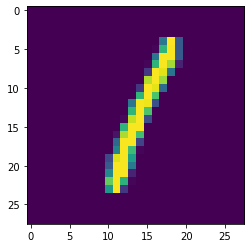

In [15]:
#demonstration -- run this cell to see the network in action
num = np.random.randint(0, 600)

plt.imshow(X_test.T[num].reshape(28, 28))
print(predict(X_test, params)[num])
plt.show()

### Save as pickle

In [ ]:
import pickle
import random
from google.colab import files

roll_num = "210051004" # enter ldap
hidden_dim = 150 # replace with your own hidden dimension

model_dict = {
    'z': hidden_dim, # hidden dimension of your model
    'layer_0_wt': params["W1"], # layer 0 weight (784, z)
    'layer_0_bias': params["b1"], # layer 0 bias (z, 1)
    'layer_1_wt': params["W2"], # layer 1 weight (z, 10)
    'layer_1_bias': params["b2"] # layer 1 bias (10, 1)
}

assert model_dict['layer_0_wt'].shape == (hidden_dim, 784)
assert model_dict['layer_0_bias'].shape == (hidden_dim, 1)
assert model_dict['layer_1_wt'].shape == (10, hidden_dim)
assert model_dict['layer_1_bias'].shape == (10, 1)

with open(f'model_{roll_num}.pkl', 'wb') as f:
    pickle.dump(model_dict, f)
    files.download(f'model_{roll_num}.pkl') # download the file from the Colab session for submission

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>